In [13]:

!pip -q install tensorboardX
!pip -q install ale-py
!pip -q install "gymnasium[atari,accept-rom-license,other]" ale-py


# Some Wrappers
___

In [1]:
import cv2
import gymnasium as gym
import ale_py
import numpy as np
import collections

gym.register_envs(ale_py)


# ========================
# FireResetEnv
# ========================
class FireResetEnv(gym.Wrapper):
    def __init__(self, env=None):
        super(FireResetEnv, self).__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, *, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)

        # Gymnasium step returns 5 values
        obs, _, terminated, truncated, info = self.env.step(1)
        if terminated or truncated:
            obs, info = self.env.reset()

        obs, _, terminated, truncated, info = self.env.step(2)
        if terminated or truncated:
            obs, info = self.env.reset()

        return obs, info

    def step(self, action):
        return self.env.step(action)


# ========================
# MaxAndSkipEnv
# ========================
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        super(MaxAndSkipEnv, self).__init__(env)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        terminated = False
        truncated = False
        info = {}

        for _ in range(self._skip):
            obs, reward, terminated, truncated, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if terminated or truncated:
                break

        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, terminated, truncated, info

    def reset(self, *, seed=None, options=None):
        self._obs_buffer.clear()
        obs, info = self.env.reset(seed=seed, options=options)
        self._obs_buffer.append(obs)
        return obs, info


# ========================
# ProcessFrame84
# ========================
class ProcessFrame84(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=(84, 84, 1), dtype=np.uint8
        )

    def observation(self, obs):
        return ProcessFrame84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 210 * 160 * 3:
            img = frame.reshape(210, 160, 3).astype(np.float32)
        elif frame.size == 250 * 160 * 3:
            img = frame.reshape(250, 160, 3).astype(np.float32)
        else:
            raise ValueError("Unknown resolution.")

        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = x_t.reshape(84, 84, 1)

        return x_t.astype(np.uint8)


# ========================
# ImageToPyTorch
# ========================
class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=0.0,
            high=1.0,
            shape=(old_shape[-1], old_shape[0], old_shape[1]),
            dtype=np.float32,
        )

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


# ========================
# ScaledFloatFrame
# ========================
class ScaledFloatFrame(gym.ObservationWrapper):
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0


# ========================
# BufferWrapper
# ========================
class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space

        self.observation_space = gym.spaces.Box(
            low=np.repeat(old_space.low, n_steps, axis=0),
            high=np.repeat(old_space.high, n_steps, axis=0),
            dtype=dtype,
        )

    def reset(self, *, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(obs), info

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer


# ========================
# make_env
# ========================
def make_env(env_name):
    env = gym.make(env_name)
    env = MaxAndSkipEnv(env, skip=4)
    env = FireResetEnv(env)
    env = ProcessFrame84(env)
    env = ScaledFloatFrame(env)        # scale BEFORE stacking
    env = ImageToPyTorch(env)          # channel last → channel first
    env = BufferWrapper(env, 4)        # frame stacking on normalized frames
    return env


# The DQN
___

In [2]:
import torch
import torch.nn as nn

import numpy as np


class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

# The Agent And Training Loop
___

In [3]:
import torch
import torch.nn as nn

import argparse
import time
import numpy as np
import collections

import torch.optim as optim

from tensorboardX import SummaryWriter

import os
print("Current working directory:", os.getcwd())

DEFAULT_ENV_NAME = "ALE/SpaceInvaders-v5"
MEAN_REWARD_BOUND = 500

GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 10000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 1000
REPLAY_START_SIZE = 10000

EPSILON_DECAY_LAST_FRAME = 10**5
EPSILON_START = 1.0
EPSILON_FINAL = 0.02


Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])


class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), np.array(next_states)


class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        
        self.state, _ = self.env.reset()
        self.total_reward = 0.0

    def play_step(self, net, epsilon=0.0, device="cpu"):
        done_reward = None

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_a = np.asarray([self.state])
            state_v = torch.tensor(state_a).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

    
        new_state, reward, terminated, truncated, _ = self.env.step(action)
        is_done = terminated or truncated # Combine terminated and truncated for 'done'
        self.total_reward += reward

        exp = Experience(self.state, action, reward, is_done, new_state)
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward


def calc_loss(batch, net, tgt_net, device):
    states, actions, rewards, dones, next_states = batch

    states_v = torch.tensor(states).to(device)
    next_states_v = torch.tensor(next_states).to(device)
    actions_v = torch.tensor(actions).to(device)
    rewards_v = torch.tensor(rewards).to(device)

    
    done_mask = torch.as_tensor(dones, dtype=torch.bool, device=device)

   
    state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)

    
    next_state_values = tgt_net(next_states_v).max(1)[0]

    
    next_state_values = next_state_values.masked_fill(done_mask, 0.0)
    next_state_values = next_state_values.detach()

    expected_state_action_values = rewards_v + GAMMA * next_state_values

    return nn.MSELoss()(state_action_values, expected_state_action_values)



if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--cuda", default=False, action="store_true", help="Enable cuda")
    parser.add_argument("--env", default=DEFAULT_ENV_NAME,
                        help="Name of the environment, default=" + DEFAULT_ENV_NAME)
    parser.add_argument("--reward", type=float, default=MEAN_REWARD_BOUND,
                        help="Mean reward boundary for stop of training, default=%.2f" % MEAN_REWARD_BOUND)
    args = parser.parse_args(['--cuda']) 
    device = torch.device("cuda" if args.cuda else "cpu")

    env = make_env(args.env) 

    net = DQN(env.observation_space.shape, env.action_space.n).to(device) 
    tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device) 
    writer = SummaryWriter(comment="-" + args.env)
    print(net)

    buffer = ExperienceBuffer(REPLAY_SIZE)
    agent = Agent(env, buffer)
    epsilon = EPSILON_START

    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
    total_rewards = []
    frame_idx = 0
    ts_frame = 0
    ts = time.time()
    best_mean_reward = None

    mean_rewards_filepath = args.env.replace("/", "_") + "_mean_rewards.csv"


    while True:
        frame_idx += 1
        epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

        reward = agent.play_step(net, epsilon, device=device)
        if reward is not None:
            total_rewards.append(reward)
            num_games = len(total_rewards)
            speed = (frame_idx - ts_frame) / (time.time() - ts)
            ts_frame = frame_idx
            ts = time.time()
            mean_reward = np.mean(total_rewards[-100:])
            print(f"{frame_idx}: done {num_games} games, mean reward {mean_reward:.3f}, eps {epsilon:.2f}, speed {speed:.2f} f/s")
            writer.add_scalar("epsilon", epsilon, frame_idx)
            writer.add_scalar("speed", speed, frame_idx)
            writer.add_scalar("reward_100", mean_reward, frame_idx)
            writer.add_scalar("reward", reward, frame_idx)

            # Save the mean reward to a file
            if num_games % 100 == 0: # Save every 100 games
                with open(mean_rewards_filepath, 'a') as f:
                    f.write(f'{num_games},{mean_reward:.2f}\n')
                print(f'Mean reward for episode {num_games} saved to {mean_rewards_filepath}')

            if best_mean_reward is None or best_mean_reward < mean_reward:
                torch.save(net.state_dict(), args.env.replace("/", "_") + "-best.dat")

                if best_mean_reward is not None:
                    print("Best mean reward updated %.3f -> %.3f, model saved" % (best_mean_reward, mean_reward))
                best_mean_reward = mean_reward
            if mean_reward > args.reward:
                print("Solved in %d frames!" % frame_idx)
                break

        if len(buffer) < REPLAY_START_SIZE:
            continue

        if frame_idx % SYNC_TARGET_FRAMES == 0:
            tgt_net.load_state_dict(net.state_dict())

        optimizer.zero_grad()
        batch = buffer.sample(BATCH_SIZE)
        loss_t = calc_loss(batch, net, tgt_net, device=device)
        loss_t.backward()
        optimizer.step()
    writer.close()

Current working directory: C:\Users\geono\AppData\Local\Programs\Microsoft VS Code
DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)
96: done 1 games, mean reward 80.000, eps 1.00, speed 530.33 f/s
232: done 2 games, mean reward 260.000, eps 1.00, speed 527.06 f/s
Best mean reward updated 80.000 -> 260.000, model saved
324: done 3 games, mean reward 193.333, eps 1.00, speed 499.90 f/s
413: done 4 games, mean reward 156.250, eps 1.00, speed 536.04 f/s
478: done 5 games, mean reward 128.000, eps 1.00, speed 526.26 f/s
544: done 6 games, mean reward 110.000, eps 0.99, speed 521.69 f/s
625: done 7 games, mean reward 98.571, ep

KeyboardInterrupt: 

#Load Data And Retrain

In [ ]:
# Load the saved model weights
model_path = args.env + "-best.dat"
if os.path.exists(model_path):
    net.load_state_dict(torch.load(model_path))
    print(f"Loaded model weights from {model_path}")
else:
    print(f"No saved model found at {model_path}, starting training from scratch.")

In [7]:
import pandas as pd

In [8]:

red_df=pd.read_csv(mean_rewards_filepath, names=['Episode', 'MeanReward'])


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt 

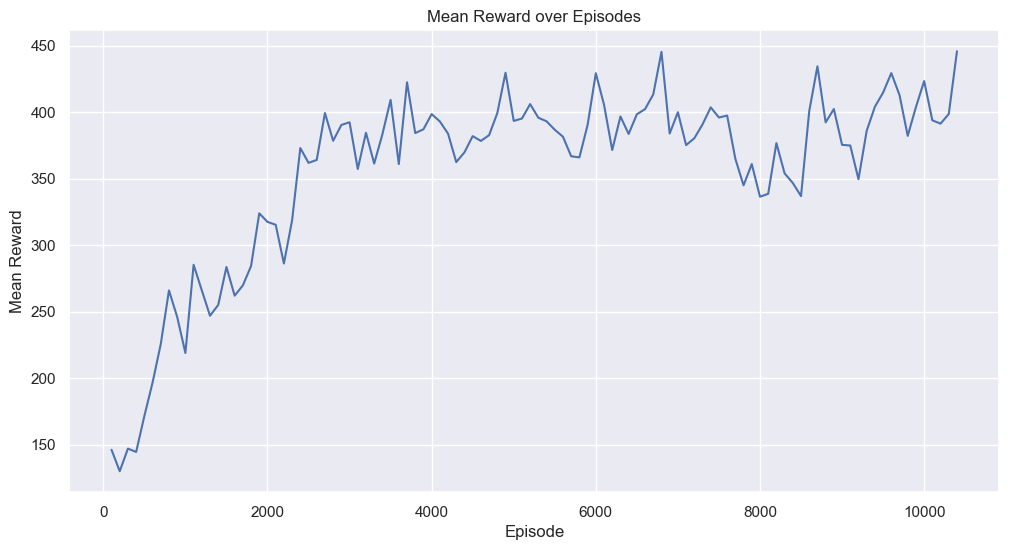

In [11]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=red_df, x='Episode', y='MeanReward')
plt.title('Mean Reward over Episodes')
plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.show()


# Second Try With Changed Wrappers
___

In [3]:
def get_lr(game_idx, total_games=10000, lr_start=0.01, lr_end=6.25e-5):
    """
    Compute a learning rate that decays exponentially from lr_start to lr_end
    over 'total_games' number of games.
    """
    
    progress = min(game_idx / total_games, 1.0)

  
    lr = lr_start * (lr_end / lr_start) ** progress
    return lr


In [7]:
import torch
import torch.nn as nn

import argparse
import time
import numpy as np
import collections

import torch.optim as optim

from tensorboardX import SummaryWriter

import os
print("Current working directory:", os.getcwd())

DEFAULT_ENV_NAME = "ALE/SpaceInvaders-v5"
MEAN_REWARD_BOUND = 500

GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 10000
#LEARNING_RATE = 6.25e-5
SYNC_TARGET_FRAMES = 1000
REPLAY_START_SIZE = 10000

EPSILON_DECAY_LAST_FRAME = 10**5
EPSILON_START = 1.0
EPSILON_FINAL = 0.02


Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])


class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), np.array(next_states)


class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        
        self.state, _ = self.env.reset()
        self.total_reward = 0.0

    def play_step(self, net, epsilon=0.0, device="cpu"):
        done_reward = None

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_a = np.asarray([self.state])
            state_v = torch.tensor(state_a).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

    
        new_state, reward, terminated, truncated, _ = self.env.step(action)
        is_done = terminated or truncated # Combine terminated and truncated for 'done'
        self.total_reward += reward

        exp = Experience(self.state, action, reward, is_done, new_state)
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward


def calc_loss(batch, net, tgt_net, device):
    states, actions, rewards, dones, next_states = batch

    states_v = torch.tensor(states).to(device)
    next_states_v = torch.tensor(next_states).to(device)
    actions_v = torch.tensor(actions).to(device)
    rewards_v = torch.tensor(rewards).to(device)

    
    done_mask = torch.as_tensor(dones, dtype=torch.bool, device=device)

   
    state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)

    
    next_state_values = tgt_net(next_states_v).max(1)[0]

    
    next_state_values = next_state_values.masked_fill(done_mask, 0.0)
    next_state_values = next_state_values.detach()

    expected_state_action_values = rewards_v + GAMMA * next_state_values

    return nn.MSELoss()(state_action_values, expected_state_action_values)



if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--cuda", default=False, action="store_true", help="Enable cuda")
    parser.add_argument("--env", default=DEFAULT_ENV_NAME,
                        help="Name of the environment, default=" + DEFAULT_ENV_NAME)
    parser.add_argument("--reward", type=float, default=MEAN_REWARD_BOUND,
                        help="Mean reward boundary for stop of training, default=%.2f" % MEAN_REWARD_BOUND)
    args = parser.parse_args(['--cuda']) 
    device = torch.device("cuda" if args.cuda else "cpu")

    env = make_env(args.env) 

    net = DQN(env.observation_space.shape, env.action_space.n).to(device) 
    tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device) 
    writer = SummaryWriter(comment="-" + args.env)
    print(net)

    buffer = ExperienceBuffer(REPLAY_SIZE)
    agent = Agent(env, buffer)
    epsilon = EPSILON_START
    new_lr = get_lr(0)
    optimizer = optim.RMSprop(net.parameters(), lr=new_lr, eps=1e-4)
    total_rewards = []
    frame_idx = 0
    ts_frame = 0
    ts = time.time()
    best_mean_reward = None

    mean_rewards_filepath = args.env.replace("/", "_") + "_mean_rewards.csv"


    while True:
        frame_idx += 1
        epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

        reward = agent.play_step(net, epsilon, device=device)
        if reward is not None:
            total_rewards.append(reward)
            num_games = len(total_rewards)
            speed = (frame_idx - ts_frame) / (time.time() - ts)
            ts_frame = frame_idx
            ts = time.time()
            mean_reward = np.mean(total_rewards[-100:])
            print(f"{frame_idx}: done {num_games} games, mean reward {mean_reward:.3f}, eps {epsilon:.2f}, speed {speed:.2f} f/s, lr: {optimizer.param_groups[0]['lr']:.6f}")
            writer.add_scalar("epsilon", epsilon, frame_idx)
            writer.add_scalar("speed", speed, frame_idx)
            writer.add_scalar("reward_100", mean_reward, frame_idx)
            writer.add_scalar("reward", reward, frame_idx)

            # Save the mean reward to a file
            if num_games % 100 == 0: # Save every 100 games
                with open(mean_rewards_filepath, 'a') as f:
                    f.write(f'{num_games},{mean_reward:.2f}\n')
                print(f'Mean reward for episode {num_games} saved to {mean_rewards_filepath}')

            if best_mean_reward is None or best_mean_reward < mean_reward:
                torch.save(net.state_dict(), args.env.replace("/", "_") + "-best.dat")

                if best_mean_reward is not None:
                    print("Best mean reward updated %.3f -> %.3f, model saved" % (best_mean_reward, mean_reward))
                best_mean_reward = mean_reward
            if mean_reward > args.reward:
                print("Solved in %d frames!" % frame_idx)
                break

        if len(buffer) < REPLAY_START_SIZE:
            continue

        if frame_idx % SYNC_TARGET_FRAMES == 0:
            tgt_net.load_state_dict(net.state_dict())

       # Update learning rate once per finished game
        if reward is not None:
            num_games = len(total_rewards)
            new_lr = get_lr(num_games)

            for param_group in optimizer.param_groups:
                param_group['lr'] = new_lr
            writer.add_scalar("learning_rate", new_lr, num_games)

    writer.close()

Current working directory: C:\Users\geono\AppData\Local\Programs\Microsoft VS Code
DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)
106: done 1 games, mean reward 20.000, eps 1.00, speed 481.81 f/s, lr: 0.010000
199: done 2 games, mean reward 45.000, eps 1.00, speed 531.43 f/s, lr: 0.010000
Best mean reward updated 20.000 -> 45.000, model saved
347: done 3 games, mean reward 98.333, eps 1.00, speed 233.07 f/s, lr: 0.010000
Best mean reward updated 45.000 -> 98.333, model saved
563: done 4 games, mean reward 131.250, eps 0.99, speed 549.62 f/s, lr: 0.010000
Best mean reward updated 98.333 -> 131.250, model saved
656: done 

KeyboardInterrupt: 